In [1]:
import numpy
import random

class Memory:   # stored as ( s, a, r, s_ ) in SumTree

    def __init__(self, capacity, e = 0.01, a = 0.6):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.size = 0
        self.e = e # error
        self.a = a # priority exponent, 0 = no priority

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, sample, error):
        p = self._getPriority(error)
        self.tree.add(p, sample) 
        self.size += 1
        if self.size > self.capacity:
            self.size = self.capacity

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, _, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)
        
    def __len__(self):
        return self.size

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [2]:
import tensorflow as tf
import sklearn.preprocessing
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

class DDPGAgent:
    def __init__(self, env, n_actions, n_features, action_low, action_high, featurize=False, reward_decay=0.95,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, learning_rate_decay=0.95,
                 memory_size=10000, priority_alpha=0.6, tau=0.9, variance=3):
        self.env = env
        self.state_size = n_features
        self.action_size = n_actions
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = reward_decay   # discount rate
        self.actor_model_set = False
        self.critic_model_set = False
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.priority_alpha = priority_alpha
        self.tau = tau # soft update
        self.batch_size = 32
        self.memory = Memory(capacity=memory_size, a=priority_alpha)
        self.variance = variance # exploration
        self.memory_size = memory_size
        self.featurize = featurize
        if featurize:
            self._init_featurizer()
        self._construct_nets()
        
    def _construct_nets(self):
        self.sess = tf.Session()
        
        self.S = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.S_ = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            self.a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, self.a_, scope='target', trainable=False)
        
        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [[tf.assign(ta, (1 - self.tau) * ta + self.tau * ea), tf.assign(tc, (1 - self.tau) * tc + self.tau * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + self.gamma * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        self.td_error_element_wise = tf.squared_difference(q_target, q)
        self.td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.ctrain = tf.train.AdamOptimizer(self.critic_learning_rate).minimize(self.td_error, var_list=self.ce_params)
           
        a_loss = - tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(self.actor_learning_rate).minimize(a_loss, var_list=self.ae_params)
        
        self.saver = tf.train.Saver() # saver
        
        self.sess.run(tf.global_variables_initializer())
    
    def _build_a(self, s, scope, trainable): # policy
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 200, activation=tf.nn.relu, name='l1', trainable=trainable)
            net = tf.layers.dense(net, 100, activation=tf.nn.relu, name='l2', trainable=trainable)
            net = tf.layers.dense(net, 30, activation=tf.nn.relu, name='l3', trainable=trainable)
            a = tf.layers.dense(net, self.action_size, activation=tf.nn.tanh, name='a', trainable=trainable)
            self.actor_model_set = True
            return a * (self.action_high-self.action_low)/2 + (self.action_high+self.action_low)/2
    
    def _build_c(self, s, a, scope, trainable): # advantage value
        with tf.variable_scope(scope):
            n_l1 = 200
            w1_s = tf.get_variable('w1_s', [self.state_size, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.action_size, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            net = tf.layers.dense(net, 100, activation=tf.nn.relu, name='l2', trainable=trainable)
            net = tf.layers.dense(net, 30, activation=tf.nn.relu, name='l3', trainable=trainable)
            self.critic_model_set = True
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)
    
    def remember(self, state, action, reward, next_state, done):
        if self.priority_alpha > 0: # prioritised
            self.memory.add((state, action, reward, next_state, done), 
                            self.error(state, action, reward, next_state))
        else: # non prioritised, every memory has priority 1
            self.memory.add((state, action, reward, next_state, done), 1)
            
    def error(self, state, action, reward, next_state):
        return self.sess.run(self.td_error, {self.S: state, self.a: [action], 
                                             self.R: [[reward]], self.S_: next_state})
        
    def choose_action(self, state, variance, low, high): # normal distribution
        assert self.actor_model_set, 'actor model not set!'
        action = self.sess.run(self.a, {self.S: state})[0]
        return np.clip(np.random.normal(action, variance), low, high)
    
    def replay(self, batch_size):
        assert self.actor_model_set, 'model not set!'
        assert self.critic_model_set, 'critic model not set!'
        minibatch = self.memory.sample(batch_size)
        idxs, states, actions, rewards, next_states = [], [], [], [], []
        for idx, (state, action, reward, next_state, _) in minibatch:
            idxs+=[idx]
            states+=[state]
            actions+=[action]
            rewards+=[reward]
            next_states+=[next_state]
        
        self.sess.run(self.atrain, {self.S: np.vstack(states)})
        self.sess.run(self.ctrain, {self.S: np.vstack(states), self.a: np.vstack(actions),
                                    self.R: np.vstack(rewards), self.S_: np.vstack(next_states)})
        self.sess.run(self.soft_replace) # update the weights
        
        if self.priority_alpha > 0: # prioritised, update
            errors = self.sess.run(self.td_error_element_wise, {self.S: np.vstack(states), self.a: np.vstack(actions),
                                                                self.R: np.vstack(rewards), self.S_: np.vstack(next_states)})
            for i in range(len(idxs)):
                self.memory.update(idxs[i], errors[i])
        
        self.actor_learning_rate *= self.learning_rate_decay
        self.critic_learning_rate *= self.learning_rate_decay


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from unityagents import UnityEnvironment

env_name = "balance_broom"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 8
        Action space type: continuous
        Action space size (per agent): 2
        Memory space size (per agent): 0
        Action descriptions: , 


In [4]:
train_mode = False
    
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]
    
# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.states[0]))

Agent state looks like: 
[ 0.  0.  0.  0.  0.  0.  0.  0.]


In [5]:
agent = DDPGAgent(env,
            n_actions=2,
            n_features=8,
            featurize=False, 
            action_high=1,
            action_low=-1,
            actor_learning_rate=0.0001,
            critic_learning_rate=0.0002,
            priority_alpha=0
            )

In [6]:
n_episodes = 3000

# agent.saver.restore(agent.sess, "model/model.ckpt")
rewards = []
for i_episode in range(n_episodes):
    env_info = agent.env.reset(train_mode=False)[default_brain]
    state = env_info.states
    r = 0
    while True:
        action = agent.choose_action(state, agent.variance, agent.action_low, agent.action_high)
        env_info = agent.env.step(action)[default_brain]
        next_state = env_info.states
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        agent.remember(state, action, reward, next_state, done)
        # learn when memory is full, every BATCH steps
        if len(agent.memory) == agent.memory_size:
            agent.variance *= 0.999995
            agent.replay(agent.batch_size)
        state = next_state
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, "explore var: %.2f" % agent.variance, end="\r")
            rewards += [r]
            break
print("\n")
print("finished learning!")
agent.saver.save(agent.sess, "model/model.ckpt");

episode: 3000 rewards: -8.76 explore var: 1.03

finished learning!


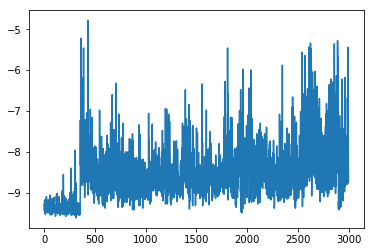

In [7]:
plt.plot(rewards)
plt.show()

In [8]:
n_episodes = 50

test_rewards = []
for i_episode in range(n_episodes):
    env_info = agent.env.reset(train_mode=False)[default_brain]
    state = env_info.states
    r = 0
    while True:
        action = agent.choose_action(state, 0, agent.action_low, agent.action_high)
        env_info = agent.env.step(action)[default_brain]
        next_state = env_info.states
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        state = next_state
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            test_rewards += [r]
            break
print("\n")
print("finished testing!")

episode: 50 rewards: -7.72

finished testing!


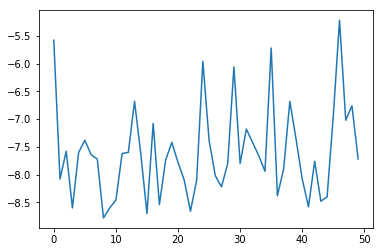

In [9]:
plt.plot(test_rewards)
plt.show()

In [10]:
env.close()